In [1]:
import wmfdata as wmf

In [2]:
(
    wmf.spark.run("""
        SELECT
            month, 
            wikimedia_region,
            SUM(IF(
                activity_level IN ('5 to 99', '100 or more'),
                namespace_zero_distinct_editors,
                0
            )) AS active_editors
        FROM wmf.unique_editors_by_country_monthly uem
        LEFT JOIN canonical_data.countries cdc
        ON uem.country_code = cdc.iso_code
        WHERE 
            users_are_anonymous = False
            AND month > '2022-01'
            AND wikimedia_region IS NOT NULL
            AND wikimedia_region != ''
        GROUP BY 
            month,
            wikimedia_region
        ORDER BY 
            month,
            wikimedia_region
    """)
    .pivot(index='month', columns='wikimedia_region', values='active_editors')
    .to_csv('resources/data/regional_editor_metrics.csv')
)

SPARK_HOME: /srv/home/nshahquinn-wmf/.conda/envs/2024-02-23T23.25.17_nshahquinn-wmf/lib/python3.10/site-packages/pyspark
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/09 02:00:53 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/09 02:00:54 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
24/04/09 02:00:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/09 02:01:03 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 13000. Attempting port 13001.
24/04/09 02:01:08 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


Generating Regional Active Editors chart...


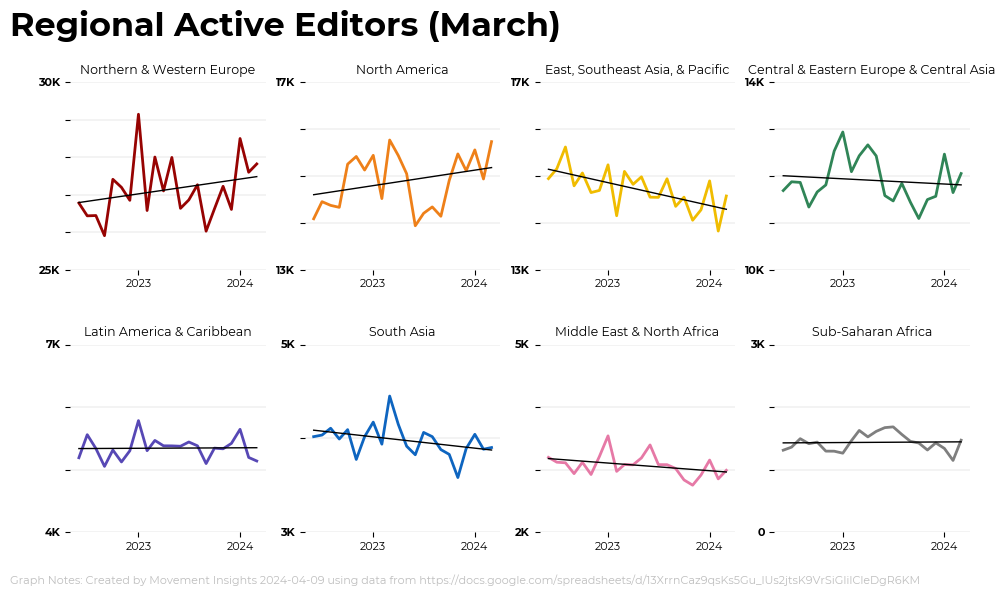

In [4]:
import pandas as pd
from datetime import date, datetime, timedelta
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import os
from os.path import dirname
import warnings
#local
#from wikicharts import Wikichart, wmf_colors, wmf_regions, split_df_by_col, gen_keys, roll
#jupyter notebook
%run wikicharts.ipynb

def main():
    print("Generating Regional Active Editors chart...")

    warnings.filterwarnings("ignore")

    #---PROMPT FOR INPUT---
    save_file_name_base = "Regional_Active_Editors"
    #note for labeling the YoY highlight
    yoy_note = " "
    #display or note
    display_flag = True

    #---CLEAN DATA--
    df = pd.read_csv(
        home_dir + '/resources/data/regional_editor_metrics.csv',
        parse_dates=["month"],
        index_col="month"
    )
    
    start_date = "2018-05-01"
    end_date = datetime.today()
    
    # Sort columns left to right from highest to lowest all-time total
    col_order = df.iloc[-1].sort_values(ascending=False).index
    df = df[col_order]
    
    # Create different dfs for each figure
    max_charts_per_figure = 8
    
    # gen_keys expects a list of data frames, with no index
    dfs = [df.reset_index()]
    
    # Generate keys that map each region to a different color
    key_colors = [wmf_colors['red'], wmf_colors['orange'], wmf_colors['yellow'], wmf_colors['green'], wmf_colors['purple'], wmf_colors['blue'], wmf_colors['pink'], wmf_colors['black50'], wmf_colors['brightblue']]
    keys = gen_keys(dfs, key_colors)
    
    #---MAKE CHARTS---
    fig_counter = 0
    total_num_charts = len(df.columns) - 1
    num_figures = ceil(total_num_charts / max_charts_per_figure)
    figures = [None] * num_figures

    def round_to_nearest(x, base=1000):
        return base * round(x / base)

    for f in range(num_figures):
        fig_counter += 1
        charts_in_figure = len(dfs[f].columns) - 1
        figures[f] = Wikichart(start_date, end_date, dfs[f])
        figures[f].init_plot(width=12, subplotsx=2, subplotsy=4, fignum=f)
        figures[f].plot_subplots_lines('month', keys[f], num_charts=charts_in_figure, subplot_title_size=9)
        figures[f].plot_multi_trendlines('month', keys[f], num_charts=charts_in_figure)

        # Set individual y-axis limits and labels for each subplot
        for i, ax in enumerate(figures[f].ax.flat):
            if i < charts_in_figure:
                region_label = keys[f].iloc[i]['labelname']
                region_data = dfs[f][region_label].dropna()
                ymin = max(0, round_to_nearest(region_data.min()) - 1000)  # Decrease by 1000 but not below 0
                ymax = round_to_nearest(region_data.max()) + 1000  # Increase by 1000 as a cushion
                ax.set_ylim(ymin, ymax)

                # Generate rounded y-ticks and labels
                y_ticks = np.arange(ymin, ymax + 1000, 1000)  # Adjust step as needed
                y_labels = [f'{int(tick/1000)}k' if tick != 0 else '0' for tick in y_ticks]
                ax.set_yticks(y_ticks)
                ax.set_yticklabels(y_labels)

        figures[f].format_subplots(title='Regional Active Editors',
                                   key=keys[f],
                                   data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
                                   num_charts=charts_in_figure,
                                   tickfontsize=8)
        figures[f].clean_ylabels_subplots(tickfontsize=8)
        save_file_name = save_file_name_base + "_" + str(f) + ".jpeg"
        figures[f].finalize_plot(save_file_name, display=False)
    
if __name__ == "__main__":
    main()